In [2]:
import pandas as pd
import numpy as np
import shap
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
    train_test_split,
    cross_val_score
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    matthews_corrcoef,
    classification_report,
    make_scorer
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


# Read Dataset

In [5]:
data = pd.read_csv(r'telecom_data.csv')

data.drop(['CustomerID'], axis = 1, inplace = True)

# Feature Engineering

In [8]:
# Create New Features

# 1. Monthly Engagement Ratio
data['MonthlyEngagementRatio'] = data['ViewingHoursPerWeek'] / data['MonthlyCharges']

# 2. Loyalty Indicator
data['LoyaltyIndicator'] = pd.cut(data['AccountAge'], 
                                   bins=[0, 12, 36, float('inf')], 
                                   labels=['New', 'Mid-Level', 'Loyal'])

# 3. Content Diversity
data['ContentDiversity'] = (data['ContentType'] == 'Both').astype(int)

# 4. Premium Cost Index
average_cost = data.groupby('SubscriptionType')['MonthlyCharges'].transform('mean')
data['PremiumCostIndex'] = data['MonthlyCharges'] > average_cost

# 5. Device Engagement
data['DeviceEngagement'] = ((data['DeviceRegistered'] != 'Unknown') & (data['MultiDeviceAccess'] == 'Yes')).astype(int)

# 6. Support Need Intensity
data['SupportNeedIntensity'] = data['SupportTicketsPerMonth'] / (data['AccountAge'] + 1)  # Avoid division by zero

# 7. Churn Risk Indicators
data['HighWatchlist'] = (data['WatchlistSize'] > 20).astype(int)

# 8. FrequentDownloader
data['FrequentDownloader'] = (data['ContentDownloadsPerMonth'] > data['ContentDownloadsPerMonth'].mean()).astype(int)

# 9. Payment Stability
stable_payment_methods = ['Bank transfer', 'Credit card']
data['PaymentStability'] = data['PaymentMethod'].isin(stable_payment_methods).astype(int)

# 10. Parental Control Impact
data['ParentalControlImpact'] = ((data['ParentalControl'] == 'Yes') & (data['SubtitlesEnabled'] == 'Yes')).astype(int)

# 11. Feature Interactions
data['SubscriptionContentInteraction'] = data['SubscriptionType'] + "_" + data['ContentType']

# Label Encoding

In [11]:
le = LabelEncoder()

data['SubscriptionType'] = le.fit_transform(data['SubscriptionType'])
data['PaymentMethod'] = le.fit_transform(data['PaymentMethod'])
data['PaperlessBilling'] = le.fit_transform(data['PaperlessBilling'])
data['ContentType'] = le.fit_transform(data['ContentType'])
data['MultiDeviceAccess'] = le.fit_transform(data['MultiDeviceAccess'])
data['DeviceRegistered'] = le.fit_transform(data['DeviceRegistered'])
data['GenrePreference'] = le.fit_transform(data['GenrePreference'])
data['Gender'] = le.fit_transform(data['Gender'])
data['ParentalControl'] = le.fit_transform(data['ParentalControl'])
data['SubtitlesEnabled'] = le.fit_transform(data['SubtitlesEnabled'])
data['LoyaltyIndicator'] = le.fit_transform(data['LoyaltyIndicator'])
data['PremiumCostIndex'] = le.fit_transform(data['PremiumCostIndex'])
data['SubscriptionContentInteraction'] = le.fit_transform(data['SubscriptionContentInteraction'])

data.drop(['TotalCharges', 'ContentType', 'DeviceEngagement', 'SubscriptionContentInteraction'], axis = 1, inplace = True)

data.head(5)

,AccountAge,MonthlyCharges,SubscriptionType,PaymentMethod,PaperlessBilling,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,...,Churn,MonthlyEngagementRatio,LoyaltyIndicator,ContentDiversity,PremiumCostIndex,SupportNeedIntensity,HighWatchlist,FrequentDownloader,PaymentStability,ParentalControlImpact
0,119,15.382382,0,1,1,1,1,28.563095,164.360194,43,...,0,1.856871,0,0,1,0.050000,1,1,1,0
1,119,16.104333,0,2,1,1,2,13.422144,56.854608,25,...,0,0.833449,0,0,1,0.000000,1,1,0,1
2,119,15.636604,0,3,0,1,3,16.542962,40.246970,25,...,0,1.057964,0,1,1,0.000000,0,1,0,1
3,119,7.005459,2,2,1,0,3,3.147423,113.853978,39,...,0,0.449281,0,0,0,0.008333,0,1,0,1
4,119,14.713919,1,2,1,0,1,31.802896,96.586233,41,...,0,2.161416,0,0,1,0.075000,1,1,0,0


# DATA SPLIT ####

In [14]:
# DATA SPLIT into Train, Test, Validation

data_train_val = data[data['AccountAge']>24]
data_test = data[data['AccountAge'] <=24]

print('data_train_val count:', data_train_val['Churn'].count())
print('data_test count:', data_test['Churn'].count())

# Assume 'Target' is the name of the target column
X = data_train_val.drop('Churn', axis=1)
y = data_train_val['Churn']

# Split the dataset into training (75%) and validation (25%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

data_train_val count: 195001
data_test count: 48786


# Standardize Data

In [17]:
# Standardize the resampled training data and the validation data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on resampled training data
X_val_scaled = scaler.transform(X_val)  # Only transform on the validation data, don't fit again

# Imbalance Rates

In [20]:
print("Default Data Imbalance Rate: ", data['Churn'].sum() / data['Churn'].count())

print("Validation Data Imbalance Rate: ", y_val.sum() / y_val.count())


print("Test Data Imbalance Rate: ", data_test['Churn'].sum() / data_test['Churn'].count())

print("Train Data Imbalance Rate: ", y_train.sum() / y_train.count())

Default Data Imbalance Rate:  0.18123197709475894
Validation Data Imbalance Rate:  0.15230456811142334
Test Data Imbalance Rate:  0.29688845160496863
Train Data Imbalance Rate:  0.1522940170940171


# Logistic Regression

In [24]:
# Define the logistic regression model with higher max_iter

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Define the refined random search hyperparameter space
param_distributions = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': ['balanced']
    },
    {
        'solver': ['lbfgs', 'newton-cg'],
        'penalty': ['l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': ['balanced']
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': ['balanced'],
        'l1_ratio': [0.1, 0.5, 0.7, 1.0]  # Only for elasticnet
    }
]


# Define StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 6: Define RandomizedSearchCV
random_search = RandomizedSearchCV(
    log_reg,
    param_distributions,
    scoring=make_scorer(f1_score, average='binary'), 
    cv=stratified_cv,  
    verbose=1,
    n_jobs=-1,
    n_iter=10, 
    random_state=42,
    error_score='raise'
)

# Measure training start time
start_time = time.time()

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train_scaled, y_train)

# Measure training end time
end_time = time.time()

# Get best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Evaluate the model on the validation set
best_model.fit(X_train_scaled, y_train)  # Retrain on the training set
y_val_pred = best_model.predict(X_val_scaled)
y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

# Validation metrics
val_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred, average='binary'),
    "Recall": recall_score(y_val, y_val_pred, average='binary'),
    "F1-Score": f1_score(y_val, y_val_pred, average='binary'),
    "Log Loss": log_loss(y_val, y_val_pred_proba),
    "Matthews Correlation Coefficient": matthews_corrcoef(y_val, y_val_pred),
    "ROC-AUC": roc_auc_score(y_val, y_val_pred_proba),
}

# Print validation metrics
print("\nValidation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Step 10: Classification Report and Confusion Matrix
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))

# Step 11: Measure and print training time
train_time = end_time - start_time
print("\nTraining Time:", round(train_time, 2), "seconds")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)



Validation Metrics:
Accuracy: 0.6726
Precision: 0.2731
Recall: 0.6917
F1-Score: 0.3916
Log Loss: 0.6011
Matthews Correlation Coefficient: 0.2664
ROC-AUC: 0.7432

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.92      0.67      0.78     41326
           1       0.27      0.69      0.39      7425

    accuracy                           0.67     48751
   macro avg       0.60      0.68      0.58     48751
weighted avg       0.82      0.67      0.72     48751


Confusion Matrix (Validation):
[[27655 13671]
 [ 2289  5136]]

Training Time: 30.76 seconds


# ROC Curve

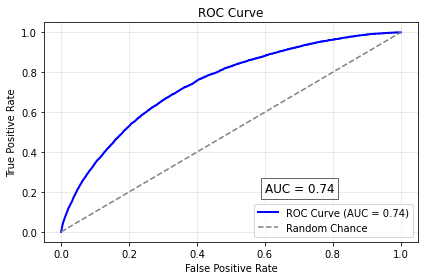

In [37]:
# Generate the ROC curve using only test set data
roc_display = RocCurveDisplay.from_predictions(
    y_val,               # True labels for the test set
    y_val_pred_proba,    # Predicted probabilities for the test set
    name="ROC Curve",
    color="blue",
    linewidth=2
)

# Add additional details
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)  # Add grid for better readability

# Optionally display the AUC
auc_score = roc_auc_score(y_val, y_val_pred_proba)
plt.text(0.6, 0.2, f"AUC = {auc_score:.2f}", fontsize=12, color="black", bbox=dict(facecolor="white", alpha=0.6))

# Show the plot
plt.tight_layout()
plt.show()

# Results of Cross Validation

In [40]:
# Access the cross-validation results
cv_results = random_search.cv_results_

# Convert the results to a DataFrame for easier inspection
cv_results_df = pd.DataFrame(cv_results)

# Extract F1-score related columns and their split-specific results
f1_scores_df = cv_results_df[
    [
        "params", 
        "mean_test_score", 
        "std_test_score", 
        "rank_test_score", 
        "split0_test_score", 
        "split1_test_score", 
        "split2_test_score", 
        "split3_test_score",
        "split4_test_score" 
 
    ]
]

# Sort by rank to see the best parameter combinations
f1_scores_df = f1_scores_df.sort_values("rank_test_score")

f1_scores_df.head(5)

,params,mean_test_score,std_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
1,"{'solver': 'saga', 'penalty': 'l2', 'l1_ratio'...",0.384955,0.003255,1,0.381007,0.390229,0.385940,0.382074,0.385524
8,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.384848,0.003278,2,0.380861,0.390225,0.385738,0.382044,0.385372
7,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.384838,0.003287,3,0.380861,0.390225,0.385738,0.381995,0.385372
6,"{'solver': 'lbfgs', 'penalty': 'l2', 'class_we...",0.384838,0.003300,4,0.380861,0.390225,0.385817,0.381940,0.385348
5,"{'solver': 'saga', 'penalty': 'elasticnet', 'l...",0.384820,0.003310,5,0.381007,0.390207,0.385693,0.381666,0.385528


# Overfiting Check - Logistic Regression

In [43]:
# Make predictions on the training data
y_train_pred = best_model.predict(X_train_scaled)
y_train_pred_proba = best_model.predict_proba(X_train_scaled)[:, 1]

# Evaluate performance on the training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')  
train_recall = recall_score(y_train, y_train_pred, average='weighted')       
train_f1 = f1_score(y_train, y_train_pred, average='weighted')              
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba) 
train_logloss = log_loss(y_train, y_train_pred_proba)       
train_mcc = matthews_corrcoef(y_train, y_train_pred)      

# Print training performance metrics
print("\nTraining Performance:")
print(f'Accuracy: {train_accuracy * 100:.2f}%')
print(f'Precision: {train_precision:.2f}')
print(f'Recall: {train_recall:.2f}')
print(f'F1 Score: {train_f1:.2f}')
print(f'Log Loss: {train_logloss:.4f}')
print(f'Matthews Correlation Coefficient: {train_mcc:.4f}')
print(f'ROC-AUC Score: {train_roc_auc:.4f}')

# Confusion matrix for training data
print('\nTraining Confusion Matrix:')
print(confusion_matrix(y_train, y_train_pred))

# Classification report for training data
print('\nTraining Classification Report:')
print(classification_report(y_train, y_train_pred))


Training Performance:
Accuracy: 66.96%
Precision: 0.82
Recall: 0.67
F1 Score: 0.71
Log Loss: 0.6030
Matthews Correlation Coefficient: 0.2557
ROC-AUC Score: 0.7373

Training Confusion Matrix:
[[82817 41160]
 [ 7166 15107]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.77    123977
           1       0.27      0.68      0.38     22273

    accuracy                           0.67    146250
   macro avg       0.59      0.67      0.58    146250
weighted avg       0.82      0.67      0.71    146250



# Confusion Matrix

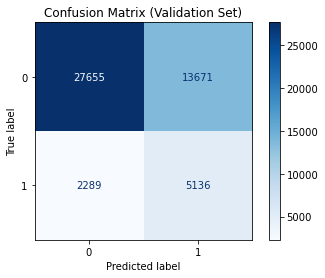

In [46]:
# Display the Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Use a blue color map for better visualization
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# Feature Importance - Coefficient Based - Logistic Regression

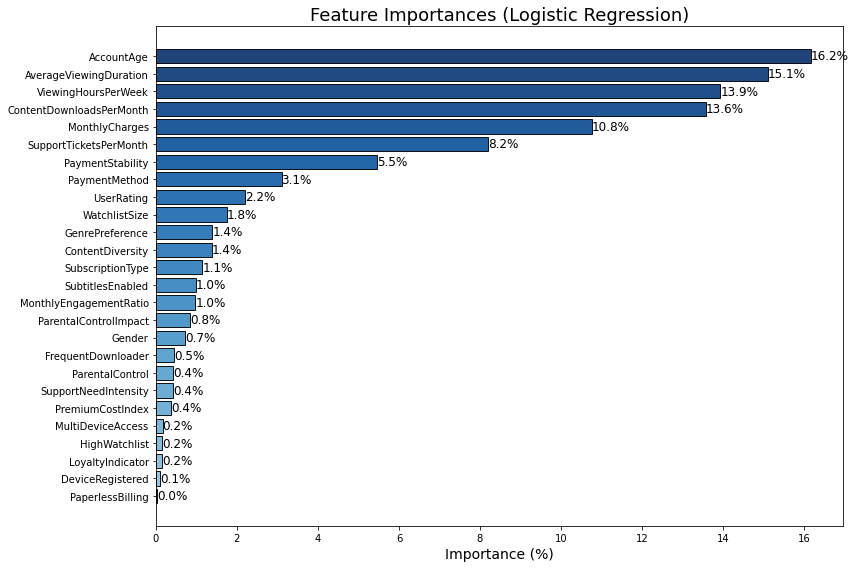

In [49]:
# Extract feature importance for Logistic Regression
feature_importance = np.abs(best_model.coef_[0])  # Absolute values of coefficients
feature_names = X.columns  # Feature names
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})

# Convert importance values to percentages
importance_df["Importance (%)"] = (importance_df["Importance"] / importance_df["Importance"].sum()) * 100

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by="Importance (%)", ascending=False)

# Plot top feature importances with color gradient
top_features = importance_df.head(30)
colors = plt.cm.Blues(np.linspace(1, 0.4, len(top_features)))

plt.figure(figsize=(12, 8))  # Increased the figure size
bars = plt.barh(
    top_features["Feature"],
    top_features["Importance (%)"],
    color=colors,
    edgecolor="black",
    alpha=0.9,
)

plt.gca().invert_yaxis()  # Highest importance at the top
plt.title("Feature Importances (Logistic Regression)", fontsize=18)
plt.xlabel("Importance (%)", fontsize=14)

# Add importance values on bars (rounded to 2 decimal places)
for bar, value in zip(bars, top_features["Importance (%)"]):
    plt.text(
        bar.get_width() + 0.001,  # Adjusted to provide more spacing
        bar.get_y() + bar.get_height() / 2,
        f"{value:.1f}%",  # Rounded to 2 decimal places
        va="center",
        fontsize=12,
    )

plt.tight_layout()
plt.show()

# Feature Importance - Coefficient Based - Values - Logistic Regression

In [52]:
# Assuming 'log_reg' is your trained Logistic Regression model and 'X' is your feature DataFrame

# Extract coefficients
coefficients = best_model.coef_[0]  # For binary classification, take the first row
absolute_coefficients = np.abs(coefficients)  # Use absolute values for importance ranking

# Pair coefficients with feature names
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": absolute_coefficients
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# (Optional) Convert to percentages
feature_importance_df["Importance (%)"] = (feature_importance_df["Importance"] / feature_importance_df["Importance"].sum()) * 100

# Display the DataFrame with feature importance values
print(feature_importance_df)

                     Feature  Importance  Importance (%)
0                 AccountAge    0.477259       16.155727
8     AverageViewingDuration    0.445832       15.091879
7        ViewingHoursPerWeek    0.411421       13.927032
9   ContentDownloadsPerMonth    0.400936       13.572119
1             MonthlyCharges    0.317597       10.751000
12    SupportTicketsPerMonth    0.242190        8.198399
24          PaymentStability    0.161200        5.456783
3              PaymentMethod    0.091679        3.103440
11                UserRating    0.065333        2.211607
14             WatchlistSize    0.051801        1.753535
10           GenrePreference    0.041239        1.395981
19          ContentDiversity    0.040929        1.385475
2           SubscriptionType    0.033842        1.145597
16          SubtitlesEnabled    0.029340        0.993194
17    MonthlyEngagementRatio    0.028906        0.978492
25     ParentalControlImpact    0.024805        0.839688
13                    Gender   

# Permutation Importance - Feature Importance Values

In [55]:
# Calculate Permutation Importance based on F1 score
perm_importance = permutation_importance(
    best_model,  # Trained logistic regression model
    X_val_scaled,  # Validation feature set
    y_val,  # Validation target
    n_repeats=10,
    random_state=42,
    scoring=make_scorer(f1_score, average="binary")  # F1 score as evaluation metric
)

# Extract permutation importance values
feature_importances = perm_importance.importances_mean
feature_names = X.columns  # Feature names from the original DataFrame

# Convert importance values to percentages
total_importance = feature_importances.sum()
feature_importance_percentages = (feature_importances / total_importance) * 100

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (%)": feature_importance_percentages
}).sort_values(by="Importance (%)", ascending=False)

# Display the updated feature importance DataFrame
feature_importance_df

,Feature,Importance (%)
0,AccountAge,23.615961
8,AverageViewingDuration,20.435256
9,ContentDownloadsPerMonth,17.180443
7,ViewingHoursPerWeek,15.897933
1,MonthlyCharges,11.566616
12,SupportTicketsPerMonth,6.363735
24,PaymentStability,2.433942
3,PaymentMethod,0.704727
17,MonthlyEngagementRatio,0.505330
14,WatchlistSize,0.484417


# Coefficients and Odds Ratios - Model interpretation


Feature Coefficients and Odds Ratios:
                     Feature  Coefficient  Odds Ratio
1             MonthlyCharges     0.317597    1.373823
12    SupportTicketsPerMonth     0.242190    1.274037
11                UserRating     0.065333    1.067515
14             WatchlistSize     0.051801    1.053167
10           GenrePreference     0.041239    1.042101
19          ContentDiversity     0.040929    1.041778
17    MonthlyEngagementRatio     0.028906    1.029328
13                    Gender     0.021445    1.021676
23        FrequentDownloader     0.013330    1.013419
21      SupportNeedIntensity     0.012430    1.012508
6           DeviceRegistered     0.003033    1.003037
4           PaperlessBilling     0.000781    1.000781
18          LoyaltyIndicator    -0.004594    0.995416
22             HighWatchlist    -0.004952    0.995060
5          MultiDeviceAccess    -0.004984    0.995028
20          PremiumCostIndex    -0.011302    0.988762
15           ParentalControl    -0.012957  

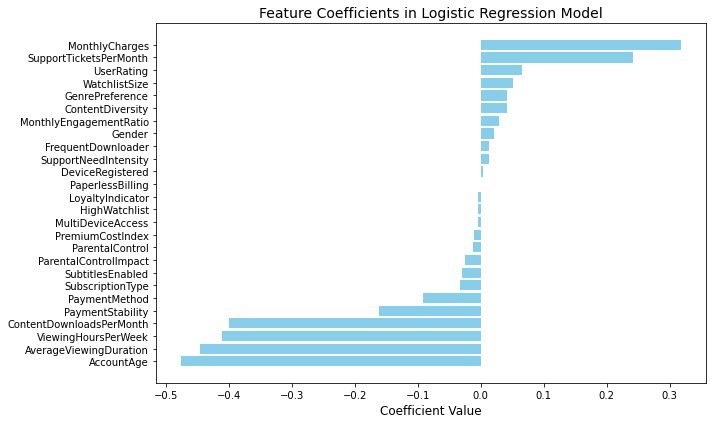

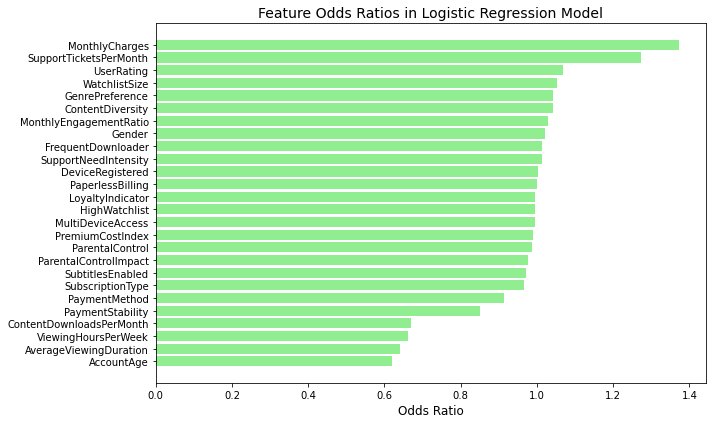

In [58]:
# Extract Coefficients and Compute Odds Ratios
coefficients = best_model.coef_[0]  # Extract coefficients from the logistic regression model
odds_ratios = np.exp(coefficients)  # Compute odds ratios

# Create a DataFrame for Coefficients and Odds Ratios
coefficients_df = pd.DataFrame({
    "Feature": X.columns,  # Assuming X.columns contains feature names
    "Coefficient": coefficients,
    "Odds Ratio": odds_ratios
}).sort_values(by="Odds Ratio", ascending=False)

# Display Coefficients and Odds Ratios
print("\nFeature Coefficients and Odds Ratios:")
print(coefficients_df)

# Save the DataFrame to a CSV File
output_file = "logistic_regression_coefficients_and_odds_ratios.csv"
coefficients_df.to_csv(output_file, index=False)
print(f"\nCoefficients and Odds Ratios have been saved to '{output_file}'.")

# Visualize Coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df["Feature"], coefficients_df["Coefficient"], color="skyblue")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.xlabel("Coefficient Value", fontsize=12)
plt.title("Feature Coefficients in Logistic Regression Model", fontsize=14)
plt.tight_layout()
plt.show()

# Visualize Odds Ratios
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df["Feature"], coefficients_df["Odds Ratio"], color="lightgreen")
plt.gca().invert_yaxis()
plt.xlabel("Odds Ratio", fontsize=12)
plt.title("Feature Odds Ratios in Logistic Regression Model", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP (SHapley Additive exPlanations)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


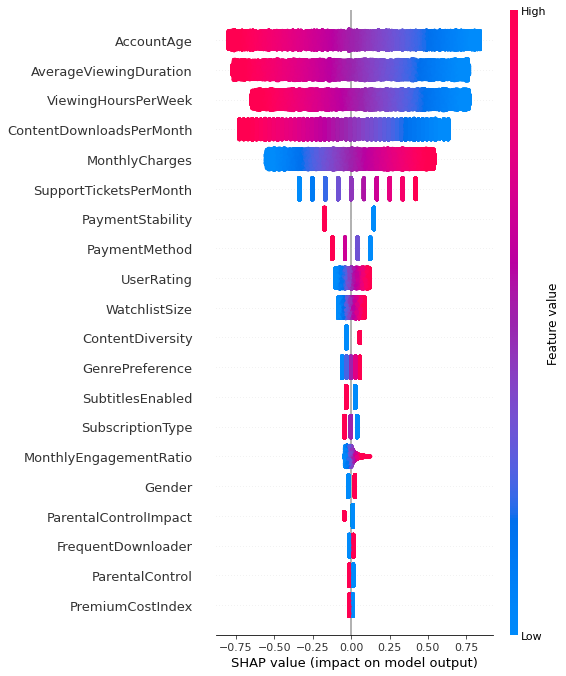

Shape of SHAP values array: (48751, 26)

Feature Importance based on Mean SHAP Values:
                     Feature  Mean SHAP Value
0                 AccountAge         0.414619
8     AverageViewingDuration         0.385473
7        ViewingHoursPerWeek         0.359529
9   ContentDownloadsPerMonth         0.348467
1             MonthlyCharges         0.275817
12    SupportTicketsPerMonth         0.210594
24          PaymentStability         0.161181
3              PaymentMethod         0.082004
11                UserRating         0.056917
14             WatchlistSize         0.044907
19          ContentDiversity         0.039372
10           GenrePreference         0.035294
16          SubtitlesEnabled         0.029333
2           SubscriptionType         0.028484
17    MonthlyEngagementRatio         0.022806
13                    Gender         0.021443
25     ParentalControlImpact         0.019947
23        FrequentDownloader         0.013330
15           ParentalControl         0.

In [61]:
# Initialize SHAP Explainer
explainer = shap.LinearExplainer(best_model, X_train_scaled, feature_perturbation="interventional")

# Compute SHAP values for the validation set
shap_values = explainer.shap_values(X_val_scaled)

# Visualize SHAP summary plot for feature importance
shap.summary_plot(shap_values, X_val_scaled, feature_names=X.columns.tolist())

# Get the shape of the SHAP values array
print("Shape of SHAP values array:", shap_values.shape)

# Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)  # Mean absolute SHAP value per feature
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Mean SHAP Value": mean_shap_values
}).sort_values(by="Mean SHAP Value", ascending=False)

print("\nFeature Importance based on Mean SHAP Values:")
print(feature_importance_df)

# Logistic Regression with Test

In [63]:
# Standardize the Test Data

# Ensure 'data_test' exists and has the correct columns
X = data_test.drop('Churn', axis=1)  
y = data_test['Churn']

# Standardize the test data using the same scaler fit on training data
X_test_scaled = scaler.transform(X)

# Make Predictions on the Test Set
y_test_pred = best_model.predict(X_test_scaled)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the Model on the Test Set
test_metrics = {
    "Accuracy": accuracy_score(y, y_test_pred),
    "Precision": precision_score(y, y_test_pred, average='binary'),  
    "Recall": recall_score(y, y_test_pred, average='binary'),        
    "F1-Score": f1_score(y, y_test_pred, average='binary'),          
    "Log Loss": log_loss(y, y_test_pred_proba),
    "Matthews Correlation Coefficient": matthews_corrcoef(y, y_test_pred),
    "ROC-AUC": roc_auc_score(y, y_test_pred_proba),
}

print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion Matrix and Classification Report for Test Set
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y, y_test_pred))


Test Metrics:
Accuracy: 0.4396
Precision: 0.3397
Recall: 0.9403
F1-Score: 0.4991
Log Loss: 0.8883
Matthews Correlation Coefficient: 0.2011
ROC-AUC: 0.7038

Confusion Matrix (Test):
[[ 7826 26476]
 [  865 13619]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.90      0.23      0.36     34302
           1       0.34      0.94      0.50     14484

    accuracy                           0.44     48786
   macro avg       0.62      0.58      0.43     48786
weighted avg       0.73      0.44      0.40     48786



# XGBClassifier

In [15]:
# Define the XGBoost classifier
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Adjust for imbalance
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
)

# Define the hyperparameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 150], 
    'learning_rate': [0.05, 0.1], 
    'max_depth': [4, 8],  
    'min_child_weight': [1, 3],  
    'subsample': [0.8], 
    'colsample_bytree': [0.8],  
    'gamma': [0],  
    'reg_alpha': [0], 
    'reg_lambda': [1]  
}


# Define RandomizedSearchCV with F1-score as the scoring metric and StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions,
    scoring=make_scorer(f1_score, average='binary'),  # Weighted F1-score for imbalanced datasets
    cv=stratified_kfold,  # Use StratifiedKFold for cross-validation
    verbose=1,
    n_jobs=-1,
    n_iter=10,  # Number of parameter settings sampled
    random_state=42,
    error_score='raise'  # Set error_score to raise for debugging
)

# Measure training start time
start_time = time.time()

# Fit the model on the scaled training data
random_search.fit(X_train_scaled, y_train)

# Measure end time for training
end_time = time.time()

# Get the best parameters and retrain the model
best_model = random_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val_scaled)
y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate the model's performance on the validation set
val_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred, average="binary"),
    "Recall": recall_score(y_val, y_val_pred, average="binary"),
    "F1-Score": f1_score(y_val, y_val_pred, average="binary"),
    "Log Loss": log_loss(y_val, y_val_pred_proba),
    "Matthews Correlation Coefficient": matthews_corrcoef(y_val, y_val_pred),
    "ROC-AUC": roc_auc_score(y_val, y_val_pred_proba),
}

print("\nValidation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion matrix and classification report for validation set
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

# Calculate and print training time
train_time = end_time - start_time
print("\nTraining Time:", round(train_time, 2), "seconds")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Validation Metrics:
Accuracy: 0.6994
Precision: 0.2828
Recall: 0.6339
F1-Score: 0.3912
Log Loss: 0.5621
Matthews Correlation Coefficient: 0.2615
ROC-AUC: 0.7360

Confusion Matrix (Validation):
[[29391 11935]
 [ 2718  4707]]

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.92      0.71      0.80     41326
           1       0.28      0.63      0.39      7425

    accuracy                           0.70     48751
   macro avg       0.60      0.67      0.60     48751
weighted avg       0.82      0.70      0.74     48751


Training Time: 34.06 seconds


# RandomForestClassifier

In [9]:
# Define the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')  # Removed redundant class_weight

# Define the hyperparameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],  # Fixed deprecated 'auto'
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

# Define RandomizedSearchCV with F1-score as the scoring metric
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    rf_model,
    param_distributions,
    scoring=make_scorer(f1_score, average="binary"),  # Ensure binary if classes are binary
    cv=stratified_kfold,
    verbose=1,
    n_jobs=-1,
    n_iter=10,  # Increased for better search
    random_state=42,
    error_score='raise'
)

# Measure training start time
start_time = time.time()

# Fit RandomizedSearchCV on the scaled training data
random_search.fit(X_train_scaled, y_train)

# Measure end time for training
end_time = time.time()

# Get the best parameters and retrain the model
best_model = random_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val_scaled)
y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]  # For log loss and ROC-AUC

# Evaluate the model's performance on the validation set
val_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred, average="binary"),  
    "Recall": recall_score(y_val, y_val_pred, average="binary"),        
    "F1-Score": f1_score(y_val, y_val_pred, average="binary"),        
    "Log Loss": log_loss(y_val, y_val_pred_proba),
    "Matthews Correlation Coefficient": matthews_corrcoef(y_val, y_val_pred),
    "ROC-AUC": roc_auc_score(y_val, y_val_pred_proba)
}

print("\nValidation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion matrix and classification report for validation set
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

# Calculate and print training time
train_time = end_time - start_time
print("\nTraining Time:", round(train_time, 2), "seconds")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Validation Metrics:
Accuracy: 0.7039
Precision: 0.2845
Recall: 0.6229
F1-Score: 0.3906
Log Loss: 0.5734
Matthews Correlation Coefficient: 0.2602
ROC-AUC: 0.7358

Confusion Matrix (Validation):
[[29693 11633]
 [ 2800  4625]]

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.91      0.72      0.80     41326
           1       0.28      0.62      0.39      7425

    accuracy                           0.70     48751
   macro avg       0.60      0.67      0.60     48751
weighted avg       0.82      0.70      0.74     48751


Training Time: 675.94 seconds


# LGBMClassifier

In [14]:
# Define the LightGBM classifier
lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')  # Handle imbalance using class_weight

# Define the hyperparameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [10, 20], 
    'num_leaves': [31, 40], 
    'min_child_samples': [10], 
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0], 
    'reg_alpha': [0, 0.1],  
    'reg_lambda': [1, 1.5],  
    'class_weight': [None, 'balanced'] 
}
# Define RandomizedSearchCV with F1-score as the scoring metric and StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    lgbm_model,
    param_distributions,
    scoring=make_scorer(f1_score, average="binary"),
    cv=stratified_kfold,  # Use StratifiedKFold
    verbose=1,
    n_jobs=-1,
    n_iter=10,  # Number of parameter settings sampled
    random_state=42,
    error_score='raise'  # Set error_score to raise for debugging
)

# Measure training start time
start_time = time.time()

# Fit RandomizedSearchCV on the scaled training data
random_search.fit(X_train_scaled, y_train)

# Measure end time for training
end_time = time.time()

# Get the best parameters and retrain the model
best_model = random_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val_scaled)
y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]  # For log loss and ROC-AUC

# Evaluate the model's performance on the validation set
val_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred, average='binary'),  # Added average
    "Recall": recall_score(y_val, y_val_pred, average='binary'),        # Added average
    "F1-Score": f1_score(y_val, y_val_pred, average='binary'),          # Added average
    "Log Loss": log_loss(y_val, y_val_pred_proba),                        # No average needed
    "Matthews Correlation Coefficient": matthews_corrcoef(y_val, y_val_pred),  # No average needed
    "ROC-AUC": roc_auc_score(y_val, y_val_pred_proba),                    # No average needed
}

print("\nValidation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion matrix and classification report for validation set
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

# Calculate and print training time
train_time = end_time - start_time
print("\nTraining Time:", round(train_time, 2), "seconds")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 22273, number of negative: 123977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1770
[LightGBM] [Info] Number of data points in the train set: 146250, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Validation Metrics:
Accuracy: 0.6759
Precision: 0.2737
Recall: 0.6820
F1-Score: 0.3906
Log Loss: 0.5868
Matthews Correlation Coefficient: 0.2642
ROC-AUC: 0.7406

Confusion Matrix (Validation):
[[27886 13440]
 [ 2361  5064]]

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.92      0.67      0.78     41326
          